In [1]:
# fix imports
from fix_imports import fix_relative_imports
fix_relative_imports()

In [2]:
from gan_network.generator import Generator
from gan_network.pix2pix_data_pipeline import get_test_dataset, get_fid_inception_dataset
import tensorflow as tf

## Plotting Generator

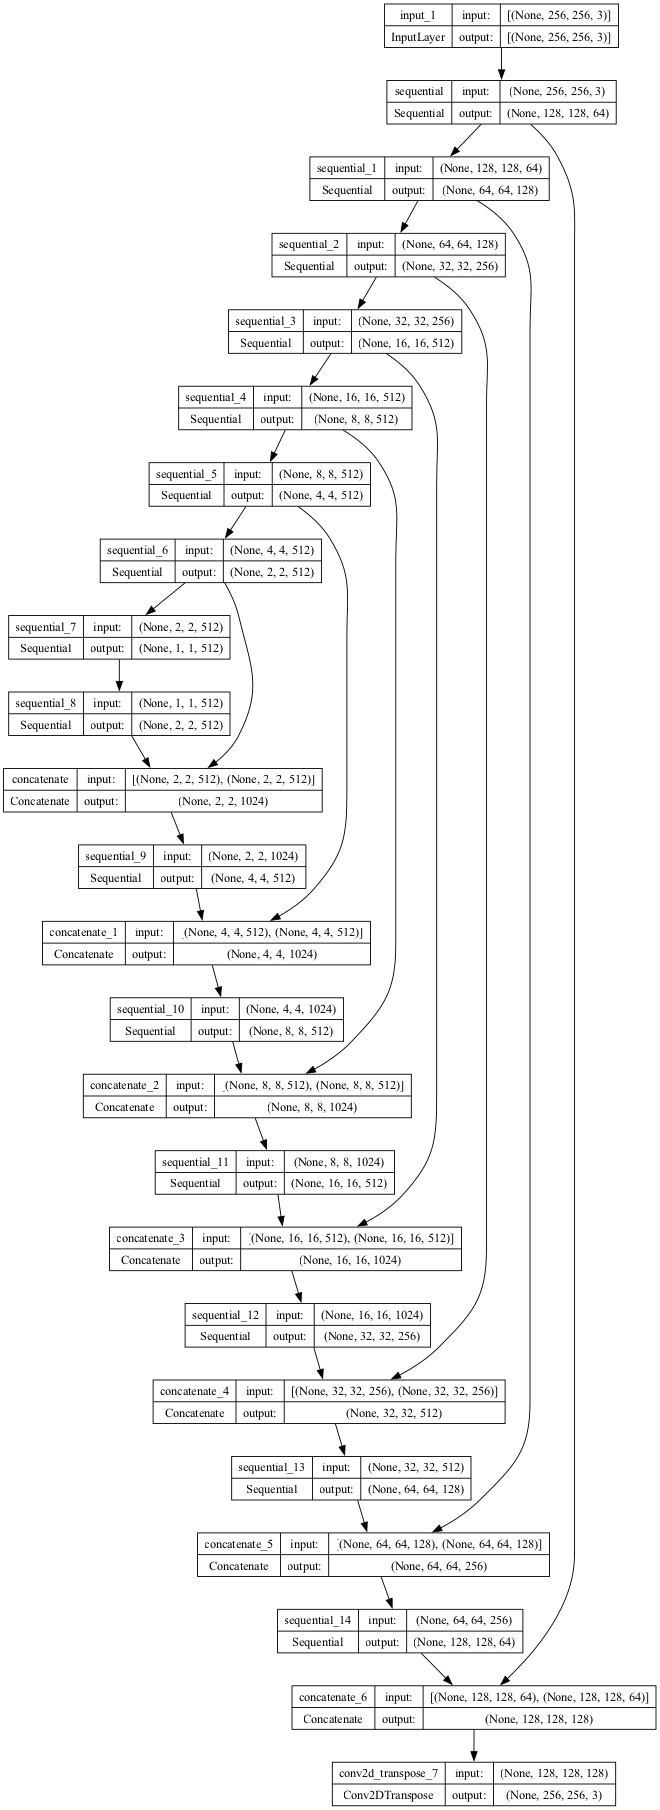

In [3]:
generator = Generator()
tf.keras.utils.plot_model(generator, to_file='generator.png', show_shapes=True, dpi=64)

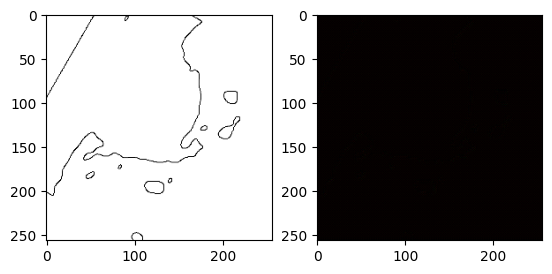

In [4]:
# test generator

from matplotlib import pyplot as plt


test_data = get_test_dataset("../data/saved_input_data")
# get only one input image from batch dataset

inp = next(iter(test_data)).input_image[0]
gen_output = generator(inp[tf.newaxis, ...], training=False)

# print input and output images
plt.subplot(1, 2, 1)
plt.imshow(inp)
plt.subplot(1, 2, 2)

plt.imshow(gen_output[0, ...])

## Plotting Discriminator

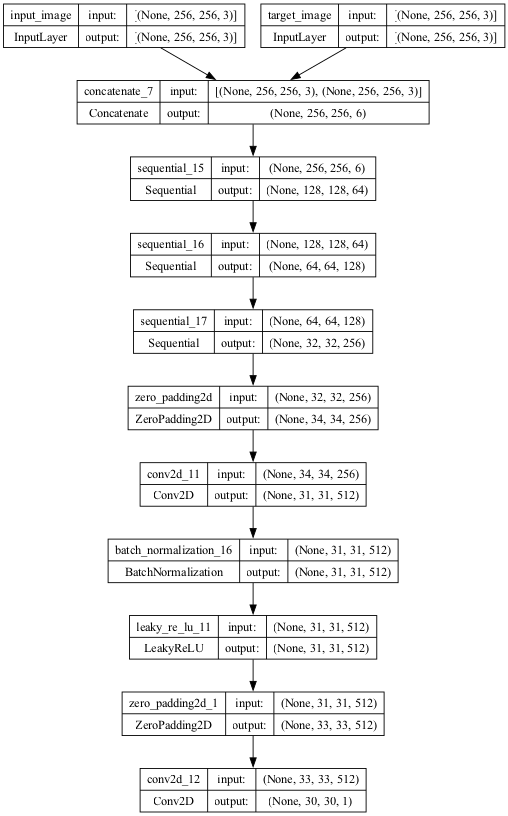

In [5]:
from gan_network.discriminator import Discriminator

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, to_file='discriminator.png', show_shapes=True, dpi=64)

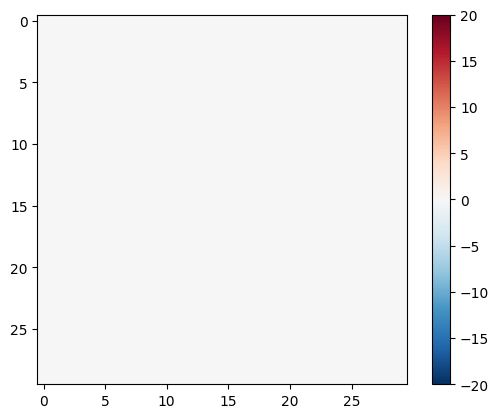

In [6]:
# test discriminator

disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.figure()
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


## Testing Model

In [7]:
from gan_network.gan_model import GanModel
CHKPT_DIR = "../data/checkpoints_2"
LOG_DIR = "../data/logs"
GENERATED_IMGS_DIR = "../data/saved_input_data_test_2_results"

gan_model = GanModel(
    checkpoint_dir=CHKPT_DIR,
    save_image_dir=GENERATED_IMGS_DIR,
    log_dir=LOG_DIR,  
    load_checkpoint=True,
)

### Test Image Generation

In [8]:
test_data = get_test_dataset("../data/saved_input_data_test_2")

# get only one input image from batch dataset
# Generates images to be evaluated through metrics
i = 0
for input_image, image in test_data:
    gan_model.generate_images(input_image[0][tf.newaxis, ...], image[0][tf.newaxis, ...], f"image_{i}.png")
    i += 1

In [9]:
# print

## Calculate Metrics
- PSNR
- SSIM
- FID
- LPIPS

In [10]:
results_folder = "../data/saved_input_data_test_2_results"

In [11]:
predicted_image_file = tf.io.read_file("../data/generated_images/prediction_aquecimento_da_mc_jane_5.png")
target_image_file = tf.io.read_file("../data/generated_images/target_aquecimento_da_mc_jane_5.png")

In [12]:
# calculate the SSIM and PSNR
predicted_image = tf.image.decode_png(predicted_image_file)
target_image = tf.image.decode_png(target_image_file)

ssim = tf.image.ssim(predicted_image, target_image, max_val=255, filter_size=11,
                        filter_sigma=1.5, k1=0.01, k2=0.03)
psnr = tf.image.psnr(predicted_image, target_image, max_val=255)

print("SSIM: ", ssim.numpy())
print("PSNR: ", psnr.numpy())

SSIM:  0.8266255
PSNR:  22.757269


### FID Score Calculation

In [13]:
"""
Inception V3 model
"""

inception_model = tf.keras.applications.InceptionV3(
    include_top=False, 
    weights='imagenet', 
    pooling='avg'
)

In [14]:
import numpy as np
from tqdm import tqdm

def compute_embeddings(dataloader, count):
    image_embeddings = []
    for _ in range(count):
        input_image = next(iter(dataloader))
        embeddings = inception_model.predict(input_image)
        image_embeddings.extend(embeddings)
        
    return np.array(image_embeddings)

In [15]:
from numpy import iscomplexobj
import numpy as np
from scipy.linalg import sqrtm

ssim = 0
psnr = 0

def calculate_fid(target_embeddings, prediction_embeddings):
    # calculate mean and covariance statistics
    mu1, sigma1 = target_embeddings.mean(axis=0), np.cov(target_embeddings, rowvar=False)
    mu2, sigma2 = prediction_embeddings.mean(axis=0), np.cov(prediction_embeddings, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [16]:
import math

BATCH_SIZE=32
count = math.ceil(10000/BATCH_SIZE)

target_data_loader = get_fid_inception_dataset(
    results_folder, 
    prefix="target_"
)
prediction_data_loader = get_fid_inception_dataset(
    results_folder, 
    prefix="prediction_"
)

target_image_embeddings = compute_embeddings(target_data_loader, count)
prediction_image_embeddings = compute_embeddings(prediction_data_loader, count)

# print shape
print("Target image embeddings shape: ", target_image_embeddings.shape)
print("Prediction image embeddings shape: ", prediction_image_embeddings.shape)

# calculate FID
fid = calculate_fid(target_image_embeddings, prediction_image_embeddings)
print("FID: ", fid)


1/1 [==============================] - 0s 42ms/step
Target image embeddings shape:  (313, 2048)
Prediction image embeddings shape:  (313, 2048)
FID:  -1.2505519544754107e+113


In [21]:
import os
import torch
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from PIL import Image
import torchvision.transforms as transforms


def torch_cov(m, rowvar=False):
    if m.dim() > 2:
        raise ValueError('m has more than 2 dimensions')
    if m.dim() < 2:
        m = m.view(1, -1)
    if not rowvar and m.size(0) != 1:
        m = m.t()
    fact = 1.0 / (m.size(1) - 1)
    m -= torch.mean(m, dim=1, keepdim=True)
    mt = m.t()  # if complex: mt = m.t().conj()
    return fact * m.matmul(mt).squeeze()

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(dim=0), torch_cov(act1.T)
    mu2, sigma2 = act2.mean(dim=0), torch_cov(act2.T)
    ssdiff = torch.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.mm(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + torch.trace(sigma1 + sigma2 - 2.0*covmean)
    return fid

def load_images(path: str, prefix: str = "target_"):
    images = []
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    for file in os.listdir(path):
        if file.startswith(prefix):
            image = Image.open(f"{path}/{file}")
            image = transform(image)
            images.append(image)
            
    return torch.stack(images) 
# Load inception model
model = inception_v3(pretrained=True, transform_input=False).eval()

# Calculate features for real and fake images
# load target images
real_imgs = load_images("../data/saved_input_data_test_2_results", prefix="target_")
fake_imgs = load_images("../data/saved_input_data_test_2_results", prefix="prediction_")

real_features = model(real_imgs).detach()
fake_features = model(fake_imgs).detach()

# Calculate FID
fid_value = calculate_fid(real_features, fake_features)
print('FID: ', fid_value)

/Volumes/KODAK/computer-vision/implementations/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Volumes/KODAK/computer-vision/implementations/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID:  tensor(166.1426)


In [22]:
import os
import shutil

for file in os.listdir("../data/saved_input_data_test_2_results"):
    if file.startswith("target_"):
        # copy file to ..data/test_target
        shutil.copyfile(f"../data/saved_input_data_test_2_results/{file}", f"../data/test_target/{file}")
        pass
    elif file.startswith("prediction_"):
        # copy file to ..data/test_predicted
        shutil.copyfile(f"../data/saved_input_data_test_2_results/{file}", f"../data/test_predicted/{file}")
        pass

FileNotFoundError: [Errno 2] No such file or directory: '../data/test_prediction/prediction_image_0.png'

In [ ]:

# loop through results folder and calculate the SSIM and PSNR between the prediction and target images
import os
import re

count = 0
ssim = 0
psnr = 0

for filename in os.listdir(results_folder):
    if filename.startswith("prediction"):
        predicted_image_file = tf.io.read_file(f"{results_folder}/{filename}")
        target_image_file = tf.io.read_file(f"{results_folder}/target_{filename[11:]}")

        predicted_image = tf.image.decode_png(predicted_image_file)
        target_image = tf.image.decode_png(target_image_file)

        ssim += tf.image.ssim(predicted_image, target_image, max_val=255, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
        psnr += tf.image.psnr(predicted_image, target_image, max_val=255)
        

        count += 1
        
print("SSIM: ", ssim.numpy()/count)
print("PSNR: ", psnr.numpy()/count)


In [ ]:
# calculate LPIPS metric
import lpips
import torch
from PIL import Image

count, lpips_distance = 0, 0

# Initiliaze the LPIPS model
loss_fn_alex = lpips.LPIPS(net='alex')

for filename in os.listdir(results_folder):
    if filename.startswith("prediction"):
        predicted_image_file = Image.open(f"{results_folder}/{filename}")
        target_image_file = Image.open(f"{results_folder}/target_{filename[11:]}")

        predicted_image = np.array(predicted_image_file)
        target_image = np.array(target_image_file)

        # Reshape the images to 3 channels
        predicted_image = np.reshape(predicted_image, (predicted_image.shape[0], predicted_image.shape[1], 3))
        target_image = np.reshape(target_image, (target_image.shape[0], target_image.shape[1], 3))

        # Convert to tensors
        predicted_image = torch.tensor(predicted_image).permute(2, 0, 1).unsqueeze(0).float()
        target_image = torch.tensor(target_image).permute(2, 0, 1).unsqueeze(0).float()

        # Calculate the LPIPS distance
        distance = loss_fn_alex(predicted_image, target_image)
        lpips_distance += distance.item()
        count += 1
        
print("LPIPS: ", lpips_distance/count)